In [46]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az
import seaborn as sns
import numpy as np
from random import randrange
from sklearn.metrics import mean_squared_error

<h1> Overview </h1>

We will compare how hyperprior choice $\tau$ affects performance of the horseshoe prior by replicating an experiment done by Piironen and Vehtari in "Sparsity information and regularization in the horseshoe and other shrinkage priors".

<h1> Generate Data </h1>

$$y_i \sim \beta_i + \epsilon_i$$
$$\epsilon_i \sim N(0, \sigma^2), \;\; i = 1, ..., 400$$
Similarly to Piironen's toy example, We generate $100$ data realizations. Our true parameter vector $\beta^*$ has length $D=400$ and $p^*=20$ non-zero entries with some value $A \in$ $\{1, 2, ..., 10\}$. The total number of observations per realization is $n=400$.

In [47]:
# Parameters
n_realizations = 2
n = 400 # number of observations, length of beta_star 
D = n 
p_star = 20 # number of non-zero predictors
sigma = 1 # noise parameter

# Generate data
def get_data(A):
    y = [] # outputs
    beta_stars = [] 
    for _ in range(n_realizations):
        # Create true beta vector beta_star
        beta_star = np.zeros(n)
        beta_star[range(20)] = A

        # Generate response variable y
        curr_y = beta_star + np.random.randn(len(beta_star)) * sigma

        # Store the generated data
        y.append(curr_y)
        beta_stars.append(beta_star)

    # Convert lists to numpy arrays 
    y = np.array(y)
    assert y.shape == (n_realizations, D), f'{y.shape}'
    beta_stars = np.array(beta_stars)
    return y, beta_stars

all_data = {}
A_values = [1, 2, 3, 4, 5, 6]
smaller_A_values = [4, 6]
for A in smaller_A_values:
    all_data[A] = get_data(A) #all_data[A] = (y, beta_stars) for that A

<h2> Define the Model </h2>

Horseshoe prior:
$$ y_i \sim N(\beta_i, \sigma^2) \quad \text{for } i = 1,2,\ldots,n$$ 
$$ \beta_i \sim N(0, \tau^2 \lambda_i^2) $$
$$ \lambda_i \sim C^+(0, 1)$$




We will compare two different hyperpriors for $\tau$: 

$\tau \sim C^+(0, 1)$ and $\tau = \tau_0 = \frac{p^*}{D-p^*}\sigma$.

In [48]:
def horseshoe_halfcauchy(y=None, sigma=1):
    '''
    Parameters:
       array y: dependent variable
       int sigma: stdev of y
    '''
    tau = numpyro.sample('tau', dist.HalfCauchy(1))
    lambdas = numpyro.sample("lambdas", dist.HalfCauchy(jnp.ones(n)))
    # slightly different parametrization for efficiency
    betas = numpyro.sample("betas", dist.Normal(0, tau*lambdas))

    kappas = numpyro.deterministic("kappas", 1 / (1 + n * tau**2 * lambdas**2))

    numpyro.sample('y', dist.Normal(betas, sigma), obs=y)

def horseshoe_tau0(y=None, sigma=1):
    '''
    Parameters:
       array y: dependent variable
       int sigma: stdev of y
    '''
    tau = (p_star / (D-p_star)) * sigma
    lambdas = numpyro.sample("lambdas", dist.HalfCauchy(jnp.ones(n)))
    # slightly different parametrization for efficiency
    betas = numpyro.sample("betas", dist.Normal(0, tau*lambdas))

    kappas = numpyro.deterministic("kappas", 1 / (1 + n * tau**2 * lambdas**2))

    numpyro.sample('y', dist.Normal(betas, sigma), obs=y)

<h1> Run and Evaluate MCMC </h1>

In [49]:
def run_mcmc_halfcauchy(tau, y):
    horseshoe_mcmc = MCMC(
        NUTS(horseshoe_halfcauchy),
        num_warmup= 500,
        num_samples= 500,
        num_chains= 2
    )
    horseshoe_mcmc.run(random.PRNGKey(2), y=y)
    return horseshoe_mcmc.get_samples()

def run_mcmc_tau0(tau, y):
    horseshoe_mcmc = MCMC(
        NUTS(horseshoe_tau0),
        num_warmup= 500,
        num_samples= 500,
        num_chains= 2
    )
    horseshoe_mcmc.run(random.PRNGKey(2), y=y)
    return horseshoe_mcmc.get_samples()

beta_samples = {}
all_mcmc_runs = []
kappa_samples = []
mean_sq_errors = {"Half-Cauchy": [0]*7, "Tau_0": [0]*7}

for A, (y, beta_stars) in all_data.items():
    beta_samples[A] = {"Half-Cauchy": [], "Tau_0": []}

    samples_halfcauchy = run_mcmc_halfcauchy("Half-Cauchy", y)
    estimated_betas_halfcauchy = samples_halfcauchy['betas'].mean(axis=0)
    mse_halfcauchy = mean_squared_error(beta_stars[0], estimated_betas_halfcauchy)
    mean_sq_errors["Half-Cauchy"][A] = mse_halfcauchy
    beta_samples[A]["Half-Cauchy"].append(estimated_betas_halfcauchy)
    kappa_samples.extend(samples_halfcauchy['kappas'])

    samples_tau0 = run_mcmc_tau0("Tau_0", y)
    estimated_betas_tau0 = samples_tau0['betas'].mean(axis=0)
    mse_tau0 = mean_squared_error(beta_stars[0], estimated_betas_tau0)
    mean_sq_errors["Tau_0"][A] = mse_tau0
    beta_samples[A]["Tau_0"].append(estimated_betas_tau0)
    kappa_samples.extend(samples_tau0['kappas'])

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_94408/2964314748.py:2: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  horseshoe_mcmc = MCMC(
sample: 100%|██████████| 1000/1000 [00:07<00:00, 129.38it/s, 20 steps of size 2.65e-03. acc. prob=0.88] 
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_94408/2964314748.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  horseshoe_mcmc = MCMC(


The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [50]:
# for mcmc in all_mcmc_runs[:5]:
#     print(az.ess(mcmc))
#     print(az.rhat(mcmc))

<h1> Results </h1>

[Text(0.5, 0, 'Entry $i$')]

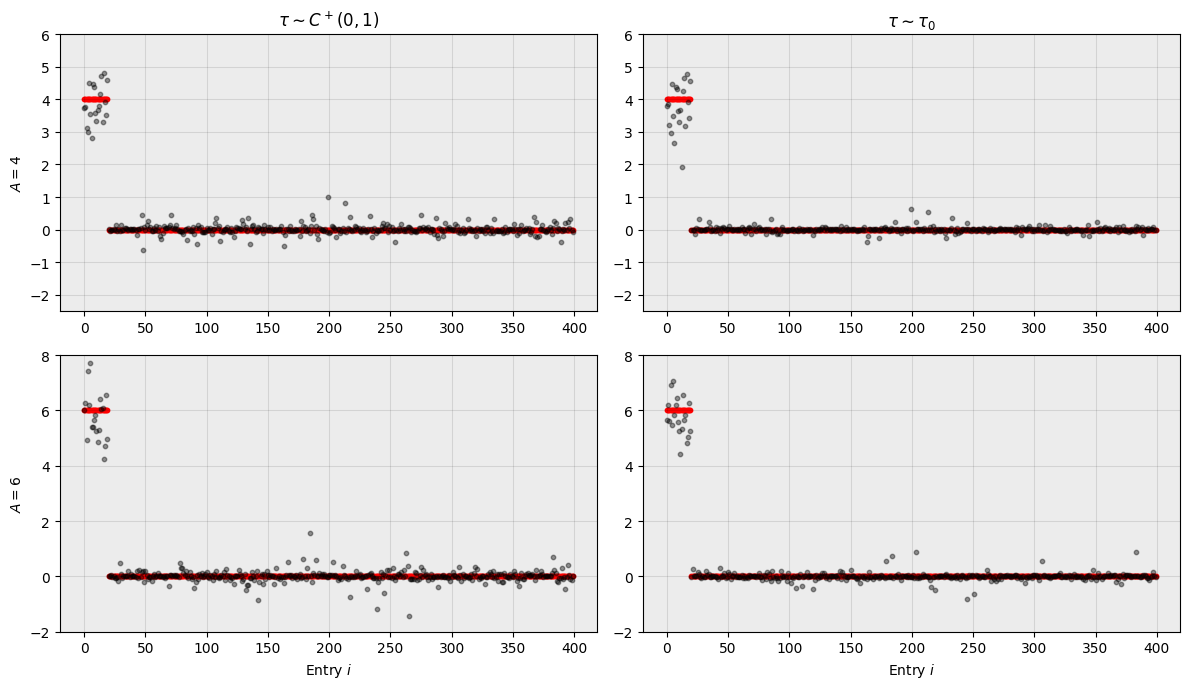

In [51]:
def plot_posterior_betas(beta_stars, y, estimated_betas, ax):
    ax.scatter(range(D), beta_stars, color='red', s=10) # plot actual betas
    ax.scatter(range(D), estimated_betas, color='black', s=10, alpha=0.4) # plot estimated betas
    # ax.scatter(range(len(y[i])), y[i], s=10, alpha=0.2, color='grey', marker='+') # plot y values


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7), layout="tight")
for ax in [ax1, ax2, ax3, ax4]: 
    ax.set_facecolor("#ECECEC") # set graph background color to grey
    ax.grid(visible=True, color="black", alpha=0.1) # add grid lines

# resetting y-axis range so that the graphs line up
ax4.set_ylim([-2, 8]) 
ax3.set_ylim([-2, 8])
ax2.set_ylim([-2.5, 6]) 
ax1.set_ylim([-2.5, 6])

d = {4: {"Half-Cauchy": ax1, "Tau_0": ax2}, 6: {"Half-Cauchy": ax3, "Tau_0": ax4}}
for A in [4, 6]:
    for tau in ["Half-Cauchy", "Tau_0"]:
        y = all_data[A][0].mean(axis=0)
        beta_stars = all_data[A][1].mean(axis=0)
        estimated_betas = beta_samples[A][tau][0]
        # print(len(beta_stars))
        # print(len(y))
        # print(len(estimated_betas))
        plot_posterior_betas(beta_stars, y, estimated_betas, d[A][tau])

# add labels to graph
ax1.set_title(r'$\tau \sim C^+(0, 1)$')
ax2.set_title(r'$\tau \sim \tau_0$')
ax1.set(ylabel=r'$A=4$')
ax3.set(ylabel=r'$A=6$', xlabel=r'Entry $i$')
ax4.set(xlabel=r'Entry $i$')


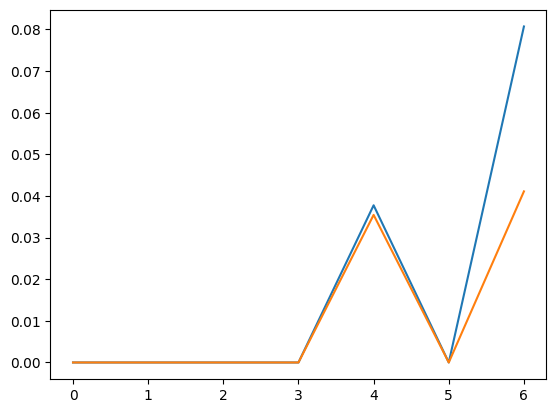

In [52]:
plt.plot(range(len(mean_sq_errors["Half-Cauchy"])), mean_sq_errors["Half-Cauchy"])
plt.plot(range(len(mean_sq_errors["Tau_0"])), mean_sq_errors["Tau_0"])

In [53]:
kappa_samples = np.ndarray.flatten(np.array(kappa_samples))
kappa_samples

array([9.2068491e-05, 2.4134885e-04, 3.9280148e-05, ..., 2.8257273e-02,
       1.3971211e-01, 3.8558760e-01], dtype=float32)

<Axes: ylabel='Density'>

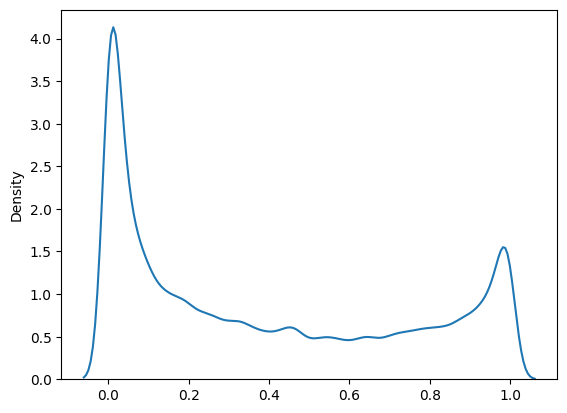

In [54]:
sns.kdeplot(kappa_samples, legend=None)